In [1]:
# Import of libraries
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle 

# Definition of state class, to make flow control easier.
# It stores what was done in the last frame
# Init - When it is first frame
# Det_full - last frame had succesfull full detection
# Det_part - last frame had succesfull partial (based on previous lines) detection
# No_det - When the detection was not succesfull in last frame
# Need_full - On cases when next frame needs full detection (e.g. too many no detect frames)
class State():
    def __init__(self):
        self.state = 'None'
        self.cam = 'Init'
        
    def detected_full(self):
        self.state = 'det_full'
        
    def detected_part(self):
        self.state = 'det_part'
        
    def no_detect(self):
        self.state = 'no_det'
        
    def need_full(self):
        self.state = 'need_full'

# Class to store previously detected lines
# It stores both left and right lane values in single object
# In the method add it does the majority of calculations:
# - calculates delta from previous detections and if too large, then rejects the new detection
# - averages (smoothes) polynomial values over multiple frames
# - sets the class variables to be used in frame processing
# - this inculdes curvature and off-center calculations
# Method no_detect - sets variables when line was not detected
# Method get_x_from_last - returns x values for Left and Right lane based on y value input

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_fitted = [] 
        self.recent_fitted_cr = [] 
        #average x values of the fitted line over the last n iterations
        #self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        #self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        self.current_fit_cr = [np.array([False])]
        #radius of curvature of the line in some units
        self.left_curverad = None
        self.right_curverad = None
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        #self.allx = None  
        #y values for detected line pixels
        #self.ally = None
        # how many frames without fit
        self.frames_wo_detection = 0
        #x,y values for detected line pixels on Left
        self.lastLeft = None  
        #x,y values for detected line pixels on Right
        self.lastRight = None  
        #difference too large
        self.diff_error = False

    def add(self, left, right, scan, left_fit_cr, right_fit_cr):
        toAdd = True
        
        if (len(self.recent_fitted)>0 and (scan!='full')):
            deltaL = abs(left[1]-self.recent_fitted[-1][0][1])
            deltaR = abs(right[1]-self.recent_fitted[-1][1][1])
            self.diffs = (deltaL, deltaR)
            if (deltaL>1.0 or deltaR>1.0):
                toAdd = False
            
        if (toAdd):
            #Adding weighted
            cnt = len(self.recent_fitted)
            if (cnt>0):
                lim = min(cnt, 7) # limit how far to look back
                left_last = self.recent_fitted[-1][0]
                right_last = self.recent_fitted[-1][1]
                left_avg = (left_last*lim+left)/(lim+1)
                right_avg = (right_last*lim+right)/(lim+1)
                self.recent_fitted.append([left_avg, right_avg])
                # same for metres
                left_last_cr = self.recent_fitted_cr[-1][0]
                right_last_cr = self.recent_fitted_cr[-1][1]
                left_avg_cr = (left_last_cr*lim+left_fit_cr)/(lim+1)
                right_avg_cr = (right_last_cr*lim+right_fit_cr)/(lim+1)
                self.recent_fitted_cr.append([left_avg_cr, right_avg_cr])

            else:
                self.recent_fitted.append([left, right])
                self.recent_fitted_cr.append([left_fit_cr, right_fit_cr])
            
            #self.recent_fitted.append([left, right])
            self.current_fit=self.recent_fitted[-1]
            self.current_fit_cr=self.recent_fitted_cr[-1]
            
            #calculate curvature
            y_eval=720
            ym_per_pix = 12/280 # meters per pixel in y dimension
            xm_per_pix = 3.7/630 # meters per pixel in x dimension

            self.left_curverad = ((1 + (2*self.current_fit_cr[0][0]*y_eval*ym_per_pix + self.current_fit_cr[0][1])**2)**1.5) / np.absolute(2*self.current_fit_cr[0][0])
            self.right_curverad = ((1 + (2*self.current_fit_cr[1][0]*y_eval*ym_per_pix + self.current_fit_cr[1][1])**2)**1.5) / np.absolute(2*self.current_fit_cr[1][0])
            
            self.radius_of_curvature = (self.left_curverad + self.right_curverad)/2
            # get off center position
            scr_middle_pix = int(1280/2)
            l,r = self.get_x_from_last(y_eval)
            line_middle_pix = int((r+l)/2)
            car_scr_offset_px = scr_middle_pix-line_middle_pix
            
            self.line_base_pos = car_scr_offset_px*xm_per_pix
            
            self.detected = True
            self.frames_wo_detection = 0
            self.diff_error = False
        else:
            self.diff_error = True
            self.detected = False
            self.frames_wo_detection +=1

    def no_detect(self):
        self.detected = False
        self.frames_wo_detection +=1
    def get_x_from_last(self, y):
        xL = self.current_fit[0][0]*y**2 + self.current_fit[0][1]*y + self.current_fit[0][2]
        xR = self.current_fit[1][0]*y**2 + self.current_fit[1][1]*y + self.current_fit[1][2]
        return xL, xR

/home/valtgun/anaconda3/envs/opencv/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)
/home/valtgun/anaconda3/envs/opencv/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)


In [2]:
def cal_camera():
    # calibrate camera 
    # load data, but if error then recalculate and save
    try:
        data = pickle.load(open('calibration.pkl', 'rb'))
        mtx = data[0]
        dist = data[1]
        #print ('Camera calibration read from file - OK')
    except:
        objpoints = []
        imgpoints = []
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x,y coords, (0,0,0)...(8,5,0)
        suc_cal_img = 0
        for i in range (1,21):
            cal_img_name = 'camera_cal/calibration'+str(i)+'.jpg'
            cal_img = cv2.imread(cal_img_name,1)
            cal_img_gray = cv2.cvtColor(cal_img, cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(cal_img_gray, (9,6),None)
            if ret == True:
                imgpoints.append(corners)
                objpoints.append(objp)
                suc_cal_img += 1
        #print ('Succesfully read # calibration images:' + str(suc_cal_img))
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, cal_img_gray.shape[::-1],None,None)
        data = [mtx,dist]
        pickle.dump(data, open('calibration.pkl', 'wb'))
        #print ('Camera calibration saved to file - OK')
    return mtx, dist

def undistort(image, mtx, dist):
    undistort_img = cv2.undistort(image, mtx, dist, None, mtx)
    return undistort_img

mtx, dist = cal_camera()
sample_img = cv2.imread('camera_cal/calibration1.jpg',1)
sample_undistort_img = undistort(sample_img, mtx, dist)
_ = cv2.imwrite('output_images/undistorted_calibration1.jpg', sample_undistort_img)

sample_img = cv2.imread('test_images/test1.jpg',1)
sample_undistort_img = undistort(sample_img, mtx, dist)
_ = cv2.imwrite('output_images/undistorted_test1.jpg', sample_undistort_img)

In [3]:
def mask_white_adaptive(img, yChan=200):
    conv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    lower_wht = np.array([yChan,0,0]) # 200,0,0
    upper_wht = np.array([255,255,255]) # 255,255,255
    mask_white = cv2.inRange(conv, lower_wht, upper_wht)
    return mask_white

def mask_hls(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    retval, binary = cv2.threshold(s.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
    return binary

def mask_sob_mag(img, kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    magGrad = np.sqrt(sobelx**2 + sobely**2)
    scale = np.max(magGrad)/255 
    magGrad = (magGrad/scale).astype(np.uint8) 
    ret, binary = cv2.threshold(magGrad, thresh[0], thresh[1], cv2.THRESH_BINARY)
    return binary

def mask_gray(image, thresh_min=180): # Not used in current pipeline
    gray = image[:,:,0]
    #plt.imshow(gray, cmap='gray')
    thresh_max = 255
    binary = np.zeros_like(gray)
    binary[(gray >= thresh_min) & (gray <= thresh_max)] = 1
    return binary

def mask_yell(img): # Not used in current pipeline
    conv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_yel = np.array([0,40,100]) # 0,40,100
    upper_yel = np.array([100,255,250]) # 100,255,250
    mask_yellow = cv2.inRange(conv, lower_yel, upper_yel)
    return mask_yellow

In [4]:
# This matrix is used for initial frames only, 
# After lines are detected, then 
def calc_transf():
    dist_src = np.float32([[585,460],[695,460],[1127,720],[203,720]])
    dist_dst = np.float32([[320,0],[960,0],[960,720],[320,720]])

    M = cv2.getPerspectiveTransform(dist_src, dist_dst)
    Minv = cv2.getPerspectiveTransform(dist_dst, dist_src)
    return M, Minv

def warp(image, M):
    warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

def warp_debug(image, M):
    img_deb = image.copy()
    warped_deb = cv2.warpPerspective(img_deb, M, (img_deb.shape[1], img_deb.shape[0]), flags=cv2.INTER_LINEAR)
    pts1 = np.array([[585,460],[695,460],[1127,720],[203,720]], np.int32)
    #pts1 = pts1.reshape((-1,1,2))
    cv2.polylines(img_deb, [pts1], True, (255,0,0), 3)
    pts2 = np.array([[320,0],[960,0],[960,720],[320,720]], np.int32)
    #pts2 = pts2.reshape((-1,1,2)) 
    cv2.polylines(warped_deb, [pts2], True, (255,0,0), 3)
    return warped_deb, img_deb


In [5]:
def find_points(img, height, mainPeak, searchRange):
    points = []
    prevPeak = mainPeak
    num_rows = int(img.shape[0]/height)
    for row in range(num_rows,-1,-1):
        startPos = max(prevPeak-searchRange, 0)
        endPos = min(prevPeak+searchRange, img.shape[1])
        mid_vert_pix = int(row*height+height/2)
        hist = np.sum(img[(row*height):(row+1)*height,startPos:endPos], axis=0, dtype=np.int32)
        #detMaxs = signal.find_peaks_cwt(hist, np.arange(1,10))
        detMaxs = np.argmax(hist)
        histRev = hist[::-1] # check reverse histogram to find if there are multiple maximum peaks
        detMaxRev = len(histRev) - np.argmax(histRev) #argmax returns first index, this line returns last
        if (detMaxs==0 and hist[0]==hist[-1]):
            detMaxs = float('NaN')
        #if len(detMaxs)>0:
        if (detMaxs==detMaxs):
            #detMaxs = int(detMaxs)
            detMaxs = int((detMaxs + detMaxRev)/2) # With multiple max peak averaging (first+last)/2
            prevPeak = 0+startPos+detMaxs
            points.append((mid_vert_pix, prevPeak))
        else:
            pass #TBD if no max found, search for different value
        
    return points

In [6]:
def get_peaks_full(img, height=20):
    midP = int(img.shape[1]/2)
    # Check peak = np.argmax(histogram)
    leftH = np.sum(img[480:,:midP], axis=0, dtype=np.int32)
    rightH = np.sum(img[480:,midP:], axis=0, dtype=np.int32)
    mainPeakL = np.argmax(leftH)
    #mainPeakL = signal.find_peaks_cwt(leftH, (np.arange(4,16)))
    #print (mainPeakL)
    mainPeakR = np.argmax(rightH)+midP
    
    #mainPeakR = np.add(signal.find_peaks_cwt(rightH, np.arange(4,16)),midP)
    #print (mainPeakR)
    if (mainPeakL==mainPeakL):
        left_pts = find_points(img, height, mainPeakL, 80)
        mainPeakL = int(np.mean(mainPeakL))
    else:
        left_pts = np.empty( shape=(0, 0) )

    if (mainPeakR==mainPeakR):
        right_pts = find_points(img, height, mainPeakR, 80)
        mainPeakR = int(np.mean(mainPeakR))
    else:
        right_pts = np.empty( shape=(0, 0) )
    
    return left_pts, right_pts, mainPeakL, mainPeakR

In [7]:
def find_points_part(img, height, searchRange, side):
    points = []
    num_rows = int(img.shape[0]/height)
    for row in range(num_rows,-1,-1):
        mid_vert_pix = int(row*height+height/2)
        
        if (side=='L'):
            prevPeak=line.get_x_from_last(mid_vert_pix)[0]
        else:
            prevPeak=line.get_x_from_last(mid_vert_pix)[1]
        
        startPos = max(prevPeak-searchRange, 0)
        endPos = min(prevPeak+searchRange, img.shape[1])
        if (startPos>=endPos):
            line.no_detect()
            break
            
        hist = np.sum(img[(row*height):(row+1)*height,startPos:endPos], axis=0, dtype=np.int32)
        #detMaxs = signal.find_peaks_cwt(hist, np.arange(1,10))
        detMaxs = np.argmax(hist)
        histRev = hist[::-1] # check reverse histogram to find if there are multiple maximum peaks
        detMaxRev = len(histRev) - np.argmax(histRev) #argmax returns first index, this line returns last
        if (detMaxs==0 and hist[0]==hist[-1]):
            detMaxs = float('NaN')
        #if len(detMaxs)>0:
        if (detMaxs==detMaxs):
            #detMaxs = int(detMaxs)
            detMaxs = int((detMaxs + detMaxRev)/2) # With multiple max peak averaging (first+last)/2
            prevPeak = 0+startPos+detMaxs
            points.append((mid_vert_pix, prevPeak))
        else:
            pass #TBD if no max found, search for different value
#            print (row)
#            print (side)
#            print (line.current_fit)
#            print (startPos, endPos)
#            print (hist)
        
    return points

In [8]:
def get_peaks_partial(img, height=20):
    left_pts = find_points_part(img, height, 40, 'L')
    right_pts = find_points_part(img, height, 40, 'R')
    mainPeakL, mainPeakR = line.get_x_from_last(img.shape[1])
    
    return left_pts, right_pts, mainPeakL, mainPeakR

In [9]:
def process_frame(image, debug='None', name='noname'):
    # get current state of detection to decide on actions to process
    # 'None', 'det_full', 'det_part', 'no_det'  
    curr_state = st.state
    # get distortion and warp matrix
    mtx, dist = cal_camera()
    M, Minv = calc_transf()
    
    # undistort input image
    undistort_img = undistort(image, mtx, dist)
       
    # apply masks and get binary output
    magthr = mask_sob_mag(undistort_img, kernel=9, thresh=(50, 250))
    hls = mask_hls(undistort_img, thresh=(88, 190))
    white = mask_white_adaptive(undistort_img)
    
    combined_mask = np.zeros_like(magthr)
    combined_mask[(magthr > 0) | (hls > 0) | (white > 0)] = 1    
    binary = warp(combined_mask, M)
    
    # warped undistorted used for debugging, binary used in pipeline
    warped = warp(undistort_img, M) 
    warp_deb, img_deb = warp_debug(undistort_img, M)
        
    
    if (debug=='Save'):
        combined_mask = np.uint8(255*combined_mask/np.max(combined_mask))
        binary = np.uint8(255*binary/np.max(binary))
        _ = cv2.imwrite('output_images/01original_'+name+'.jpg', image)
        _ = cv2.imwrite('output_images/02undistorted_'+name+'.jpg', undistort_img)
        _ = cv2.imwrite('output_images/03sobel_magnitude_'+name+'.jpg', magthr)
        _ = cv2.imwrite('output_images/04hls_s_'+name+'.jpg', hls)
        _ = cv2.imwrite('output_images/05white_yuv_'+name+'.jpg', white)
        _ = cv2.imwrite('output_images/06combined_mask_'+name+'.jpg', combined_mask)
        _ = cv2.imwrite('output_images/09warped_mask_'+name+'.jpg', binary)
        _ = cv2.imwrite('output_images/p0persp_transf_orig_'+name+'.jpg', img_deb)
        _ = cv2.imwrite('output_images/p1persp_transf_warped_'+name+'.jpg', warp_deb)
    
    # get line points
    left_pts = np.empty(shape=(0,0))
    right_pts = np.empty(shape=(0,0))
    deb_text = ''
    scan = ''
    
    if (curr_state=='det_full' or curr_state=='det_part'):
        # Detected on previous frame
        # This frame: detect partial based on previous full frame
        left_pts, right_pts, mainPeakL, mainPeakR = get_peaks_partial(binary)
        left_pts = np.array(left_pts, dtype=np.int32)
        right_pts = np.array(right_pts, dtype=np.int32)
        scan = 'part'
        if (left_pts.shape[0]>0 and right_pts.shape[0]>0):
            deb_text = 'Partial, detected L:' + str(len(left_pts))+' | R:' +str(len(right_pts))
            st.detected_part()
            line.lastLeft=left_pts
            line.lastRight=right_pts
        else:
            deb_text = 'Partial, not detected!'
            line.no_detect()
            st.no_detect()
            left_pts = line.lastLeft
            right_pts = line.lastRight

    elif (curr_state=='no_det'):
        # Did not detect in previous frame
        # Deciding to detect partial or full
        
        if (line.frames_wo_detection<=10):
            left_pts, right_pts, mainPeakL, mainPeakR = get_peaks_partial(binary)
            left_pts = np.array(left_pts, dtype=np.int32)
            right_pts = np.array(right_pts, dtype=np.int32)
            deb_text = 'noDet - Part, detected L:' + str(len(left_pts))+' | R:' +str(len(right_pts))
            scan = 'part'
            if (left_pts.shape[0]>0 and right_pts.shape[0]>0):
                deb_text = 'Partial after not detected, detected L:' + str(len(left_pts))+' | R:' +str(len(right_pts))
                st.detected_part()
                line.lastLeft=left_pts
                line.lastRight=right_pts
            else:
                deb_text = 'Partial after not detected, not detected! #:' + str(line.frames_wo_detection)
                line.no_detect()
                st.no_detect()
                left_pts = line.lastLeft
                right_pts = line.lastRight


        else:
            left_pts, right_pts, mainPeakL, mainPeakR = get_peaks_full(binary)
            left_pts = np.array(left_pts, dtype=np.int32)
            right_pts = np.array(right_pts, dtype=np.int32)
            scan = 'full'
            if (left_pts.shape[0]>0 and right_pts.shape[0]>0):
                deb_text = 'Full  after not detected, detected L:' + str(len(left_pts))+' | R:' +str(len(right_pts))
                st.detected_full()
                line.lastLeft=left_pts
                line.lastRight=right_pts
            else:
                deb_text = 'Full after not detected, not detected! #:' + str(line.frames_wo_detection)
                line.no_detect()
                st.need_full()
    else:
        # Initial detection, need full or unknown state - full detection
        left_pts, right_pts, mainPeakL, mainPeakR = get_peaks_full(binary)
        left_pts = np.array(left_pts, dtype=np.int32)
        right_pts = np.array(right_pts, dtype=np.int32)
        scan = 'full'
        if (left_pts.shape[0]>0 and right_pts.shape[0]>0):
            deb_text = 'Full, detected L:' + str(len(left_pts))+' | R:' +str(len(right_pts))
            st.detected_full()
            line.lastLeft=left_pts
            line.lastRight=right_pts
        else:
            deb_text = 'Full, not detected!'
            line.no_detect()
            #st.no_detect()
    
    
    # as output we need left_pts and right_pts in any case
    drawing = np.zeros_like(warped)
    
    # Draw diagnostic lines and points
    try:
        if (mainPeakL==mainPeakL):
            cv2.line(drawing, (mainPeakL, 600), (mainPeakL, 720), (0,255,255), thickness=4)
        if (mainPeakR==mainPeakR):
            cv2.line(drawing, (mainPeakR, 600), (mainPeakR, 720), (0,255,255), thickness=4)
    except:
        pass
    peak = drawing.copy()
    # Calculate lines from points
    y_eval = np.max(720)
    yvals = np.linspace(0, 100, num=101)*7.2
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 12/280 # meters per pixel in y dimension
    xm_per_pix = 3.7/630 # meters per pixel in x dimension

    
    
    if (left_pts.shape[0]>0 and right_pts.shape[0]>0):
        leftTtB = left_pts[::-1]
        yvalsx = leftTtB[:,0]
        leftx = leftTtB[:,1]
        left_fit = np.polyfit(yvalsx, leftx, 2)

        rightTtB = right_pts[::-1]
        yvalsy = rightTtB[:,0]
        rightx = rightTtB[:,1]
        right_fit = np.polyfit(yvalsy, rightx, 2)

        l_x = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
        pts_left = np.array([np.transpose(np.vstack([l_x, yvals]))])

        r_x = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
        pts_right = np.array([np.flipud(np.transpose(np.vstack([r_x, yvals])))])

        left_fit_cr = np.polyfit(yvalsx*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(yvalsy*ym_per_pix, rightx*xm_per_pix, 2)
        #left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        #right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        
        
    if (st.state == 'det_full' or st.state == 'det_part'):
        line.add(left_fit, right_fit, scan, left_fit_cr, right_fit_cr)
        if (st.cam == 'Init'):
            st.cam = 'Calc'

    # Drawing results on road image
   
    # Points that has been detected in frame
    if (debug=='Save'):
        _ = cv2.imwrite('output_images/14mid_lines_'+name+'.jpg', drawing)

    for i in range(len(left_pts)):
        cv2.circle(drawing, (left_pts[i,1],left_pts[i,0]), 2, (255, 0, 0), thickness=4)
        cv2.circle(drawing, (left_pts[i,1],left_pts[i,0]), 4, (255, 0, 0), thickness=4)
    for i in range(len(right_pts)):
        cv2.circle(drawing, (right_pts[i,1],right_pts[i,0]), 2, (255, 0, 0), thickness=4)
        cv2.circle(drawing, (right_pts[i,1],right_pts[i,0]),4, (255, 0, 0), thickness=4)
    
    points = drawing.copy()
    if (debug=='Save'):
        _ = cv2.imwrite('output_images/15points_'+name+'.jpg', drawing)

    if (left_pts.shape[0]>0 and right_pts.shape[0]>0):
        cv2.polylines(drawing, np.int_([pts_left]), False, (0,0,255), 3)
        cv2.polylines(drawing, np.int_([pts_right]), False, (0,0,255), 3)
    
    polylines = drawing.copy()
    if (debug=='Save'):
        _ = cv2.imwrite('output_images/16polylines_'+name+'.jpg', drawing)

        
    # Draw filled polygon
    if (left_pts.shape[0]>0 and right_pts.shape[0]>0):
        pts = np.hstack((pts_left, pts_right))
        cv2.fillPoly(drawing, np.int_([pts]), (0,255, 0))
       
    # Reverse prespective transform of the detected information
    drawing2 = cv2.warpPerspective(drawing, Minv, (drawing.shape[1], drawing.shape[0]))
    # Adding detection result on top of undistorted image
    result = cv2.addWeighted(undistort_img, 1, drawing2, 0.3, 0)
    
    if (debug=='Save'):
        _ = cv2.imwrite('output_images/20plotted_'+name+'.jpg', drawing)
        _ = cv2.imwrite('output_images/21plotted_unwarp_'+name+'.jpg', drawing2)
        _ = cv2.imwrite('output_images/22result_'+name+'.jpg', result)

   
    # Start of Additional text information    
    
    font = cv2.FONT_HERSHEY_SIMPLEX

#    cv2.putText(result, 'Diff:'+str(line.diffs), (40,40), font, .5,(255,255,255),2,cv2.LINE_AA)
#    if (line.frames_wo_detection>0):
#        cv2.putText(result, 'NoDet:'+str(line.frames_wo_detection), (40,80), font, .5,(255,255,255),2,cv2.LINE_AA)
#    cv2.putText(result, deb_text, (40,120), font, .5,(255,255,255),2,cv2.LINE_AA)
    
    #Curvature
    if (st.state == 'det_full' or st.state == 'det_part'):
        curvature = int((line.left_curverad + line.right_curverad) / 2)
    else:
        curvature = 0
    if (curvature<4000):
        cv2.putText(result, 'Curvature:'+str(curvature)+'m', (40,40), font, .5,(255,255,255),2,cv2.LINE_AA)
    else:
        cv2.putText(result, 'Curvature: straight', (40,40), font, .5,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result, 'Left:'+str(line.left_curverad) + '   Right:'+str(line.right_curverad), (40,200), font, .5,(255,255,255),2,cv2.LINE_AA)
    
    # Offcenter
    if (st.state == 'det_full' or st.state == 'det_part'):
        car_pos = int(line.line_base_pos*100)
    else:
        car_pos = 0
    if (car_pos<0):
        cv2.putText(result, 'Distance from center:'+str(abs(car_pos))+'cm Left', (40,80), font, .5,(255,255,255),2,cv2.LINE_AA)
    else:
        cv2.putText(result, 'Distance from center:'+str(abs(car_pos))+'cm Right', (40,80), font, .5,(255,255,255),2,cv2.LINE_AA)

    # End of Additional text information

    
    
    if (debug=='Save'):
        _ = cv2.imwrite('output_images/23result_text'+name+'.jpg', result)
    
    
    # ------------- Diagnostics -------------------
    #diag = True
    
    # middle panel text example
    # using cv2 for drawing text in diagnostic pipeline.
    if (debug=='Debug1'):
        combined_mask = cv2.cvtColor(np.uint8(255*combined_mask/np.max(combined_mask)), cv2.COLOR_GRAY2RGB)
        binary = cv2.cvtColor(np.uint8(255*binary/np.max(binary)), cv2.COLOR_GRAY2RGB)
        magthr = cv2.cvtColor(magthr, cv2.COLOR_GRAY2RGB)
        white = cv2.cvtColor(white, cv2.COLOR_GRAY2RGB)
        hls = cv2.cvtColor(hls, cv2.COLOR_GRAY2RGB)

        diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
        diagScreen[0:360, 0:640] = cv2.resize(image, (640,360), interpolation=cv2.INTER_AREA) 
        diagScreen[0:360, 640:1280] = cv2.resize(undistort_img, (640,360), interpolation=cv2.INTER_AREA) 
        diagScreen[0:360, 1280:1920] = cv2.resize(result, (640,360), interpolation=cv2.INTER_AREA) 
        diagScreen[360:720, 0:640] = cv2.resize(magthr, (640,360), interpolation=cv2.INTER_AREA) 
        diagScreen[360:720, 640:1280] = cv2.resize(white, (640,360), interpolation=cv2.INTER_AREA) 
        diagScreen[360:720, 1280:1920] = cv2.resize(drawing2, (640,360), interpolation=cv2.INTER_AREA) 
        diagScreen[720:1080, 0:640] = cv2.resize(hls, (640,360), interpolation=cv2.INTER_AREA) 
        diagScreen[720:1080, 640:1280] = cv2.resize(combined_mask, (640,360), interpolation=cv2.INTER_AREA) 
        diagScreen[720:1080, 1280:1920] = cv2.resize(binary, (640,360), interpolation=cv2.INTER_AREA) 
        return diagScreen

    if (debug=='Debug2'):
        binary = cv2.cvtColor(np.uint8(255*binary/np.max(binary)), cv2.COLOR_GRAY2RGB)

        diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
        diagScreen[0:360, 0:640] = cv2.resize(image, (640,360), interpolation=cv2.INTER_AREA) 
        diagScreen[0:360, 640:1280] = cv2.resize(result, (640,360), interpolation=cv2.INTER_AREA) 
        diagScreen[0:360, 1280:1920] = cv2.resize(img_deb, (640,360), interpolation=cv2.INTER_AREA) 
        diagScreen[360:720, 0:640] = cv2.resize(warped, (640,360), interpolation=cv2.INTER_AREA) 
        diagScreen[360:720, 640:1280] = cv2.resize(binary, (640,360), interpolation=cv2.INTER_AREA) 
        diagScreen[360:720, 1280:1920] = cv2.resize(warp_deb, (640,360), interpolation=cv2.INTER_AREA) 
        diagScreen[720:1080, 0:640] = cv2.resize(points, (640,360), interpolation=cv2.INTER_AREA) 
        diagScreen[720:1080, 640:1280] = cv2.resize(polylines, (640,360), interpolation=cv2.INTER_AREA) 
        diagScreen[720:1080, 1280:1920] = cv2.resize(drawing, (640,360), interpolation=cv2.INTER_AREA) 
        return diagScreen

    
    #font = cv2.FONT_HERSHEY_COMPLEX
    #middlepanel = np.zeros((120, 1280, 3), dtype=np.uint8)
    #cv2.putText(middlepanel, 'Estimated lane curvature: ERROR!', (30, 60), font, 1, (255,0,0), 2)
   
    return result

In [10]:
from sklearn.externals import joblib
from sklearn.svm import LinearSVC
from skimage.feature import hog
#Load classifier
svc = joblib.load('svc_classifier.pkl')
X_scaler = joblib.load('scaler.pkl')

/home/valtgun/anaconda3/envs/opencv/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)
/home/valtgun/anaconda3/envs/opencv/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)


In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        #print (len(spatial_features))
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        #print (len(hist_features))
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        #print (len(hog_features))
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=True)
        #### Add hog region extraction, need size 4704
        #### 
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def add_heat(heatmap, bboxes):
    # Iterate through list of bboxes
    for box in bboxes:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1.0
    
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [12]:
# Here is the function to search one image and check if regions are classified as car
# If yes then add to heatmap

def process_frame_det(image):
    curr_state = st.state
    mtx, dist = cal_camera()
    M, Minv = calc_transf()
    
    
    color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 8  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    
    y_start_stop = [400, None] # Min and max in y to search in slide_window()

    
    # undistort input image
    undistort_img = undistort(image, mtx, dist)
    
    draw_image = np.copy(undistort_img)
    
    windows1 = slide_window(undistort_img, x_start_stop=[None, None], y_start_stop=[380,480], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.75))
    windows2 = slide_window(undistort_img, x_start_stop=[None, None], y_start_stop=[400,560], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.75))
    windows3 = slide_window(undistort_img, x_start_stop=[None, None], y_start_stop=[440,None], 
                    xy_window=(164, 164), xy_overlap=(0.5, 0.75))    
    windows = windows1 + windows2 + windows3
    #TODO - faster
    #hot_windows = search_windows(undistort_img, windows, svc, X_scaler, color_space=color_space, 
    hot_windows = search_windows(undistort_img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
    
    heat = np.zeros_like(undistort_img[:,:,0]).astype(np.float32)
    heat = add_heat(heat, hot_windows)
    heat = apply_threshold(heat,1)
    
    labels = label(heat)
    #print(labels[1], 'cars found')  # labels[1] contain items found
    #result = labels[0] # labels[0] contain labeled heatmap
    
    img_lab_cars = draw_labeled_bboxes(undistort_img, labels)

    #window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    #heat = cv2.cvtColor(heat, cv2.COLOR_GRAY2RGB)
    #heat = cv2.cvtColor(np.uint8(255*heat/np.max(heat)), cv2.COLOR_GRAY2RGB)
    
    heat = np.uint8(255*heat/np.max(heat))
    heatres = np.zeros_like(undistort_img).astype(np.uint8)
    heatres[:,:,0] = heat
    
    
    result = cv2.addWeighted(img_lab_cars, 1, heatres, 1, 0)
    
    return result

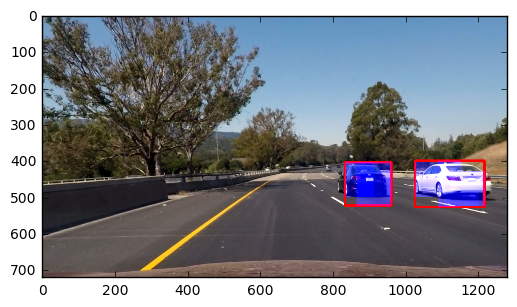

In [13]:
import multiprocessing as mp
#768
#48
#4704
#Generate examples of the straight road
st = State()
line = Line()
image = cv2.imread('test_images/test6.jpg',1)
#print (image.shape)
result = process_frame_det(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(result)

In [14]:
# Generate project video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
st = State()
line = Line()
white_output = 'out_test_video.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_frame_det)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video out_test_video.mp4
[MoviePy] Writing video out_test_video.mp4


 97%|█████████▋| 38/39 [00:46<00:01,  1.23s/it]      | 1/39 [00:01<00:46,  1.23s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_test_video.mp4 

CPU times: user 46.7 s, sys: 164 ms, total: 46.9 s
Wall time: 48 s


In [ ]:
# Generate project video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
st = State()
line = Line()
white_output = 'out_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_frame_det)
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
#Generate examples of the test pipeline
st = State()
line = Line()
image = cv2.imread('test_images/test2.jpg',1)
result = process_frame(image, debug='Save', name='test')

#Generate examples of the straight road
st = State()
line = Line()
image = cv2.imread('test_images/straight_lines1.jpg',1)
result = process_frame(image, debug='Save', name='straight1')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#plt.imshow(image)

In [ ]:
# Generate project video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
st = State()
line = Line()
white_output = 'out_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
def process_frame_d1(image):
    result = process_frame(image, debug='Debug1')
    return result

# Generate project video - debugging 1
from moviepy.editor import VideoFileClip
from IPython.display import HTML
st = State()
line = Line()
white_output = 'out_project_video_debug1.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_frame_d1)
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
def process_frame_d2(image):
    result = process_frame(image, debug='Debug2')
    return result

# Generate project video - debugging 2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
st = State()
line = Line()
white_output = 'out_project_video_debug2.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_frame_d2)
%time white_clip.write_videofile(white_output, audio=False)